In [1]:
# import libraries
import pandas as pd
import numpy as np
import pickle5 as pickle
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from skimage.transform import resize as sk_resize

from scipy import ndimage
import cv2

from helpers import *

#### Create Dataset for Detect Model
- Undersample train dataset that has been resized to 224x224 and median filtered 7x7
- Keep only 30,000 none samples randomly

In [ ]:
# load data
data = load('WM-clean-id224filter7-train.zip')
print(data.shape)
data.head()

In [ ]:
# make list of none indices
none_df = data[data.detectLabels == 0]
none_list = none_df.index.tolist()
print(f'None count: {len(none_list)}')

# make list of defect indices
def_df = data[data.detectLabels == 1]
def_list = def_df.index.tolist()
print(f'Defect count: {len(def_list)}')

In [ ]:
# randomly undersample none list
from random import sample
under_none = sample(none_list, 30000)

# sanity check
len(under_none)

In [ ]:
# recombine defect indices with undersampled none indices
new_list = sorted(under_none + def_list)
print(f'Undersampled dataset count: {len(new_list)}')

In [ ]:
# undersample data
undersampled = data.iloc[new_list].reset_index(drop=True)
print(undersampled.shape)
undersampled.head()

In [ ]:
# save undersampled dataset
# save(undersampled, 'WM-clean-id224filter7-train-detect.zip')

#### Create Dataset for Classify Model
Two approaches: 
- Random transformations on dataset as-is
- Random transformations on train set correctly classified by KNN

##### As-is (Filtered)

In [2]:
# load data
data = load('WM-clean-id224filter7-train.zip')

# df for classification model
def_df = data[data.detectLabels == 1]
print(len(def_df))
def_df.head()

17863


,ID,dieSize,lotName,failureType,dataset,detectLabels,classifyLabels,filterMap7
25,36,2460.0,lot2,Edge-Loc,train,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
26,37,2460.0,lot2,Edge-Loc,train,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
27,38,2460.0,lot2,Edge-Loc,train,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
28,39,2460.0,lot2,Loc,train,1,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
29,41,2460.0,lot2,Edge-Loc,train,1,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [3]:
# figure out max count for balancing
max_count = max(def_df.groupby('classifyLabels')['ID'].count().tolist())

# dataframe for collecting all samples
aug_df = pd.DataFrame()

for i in range(8):
    labels = def_df[def_df.classifyLabels == (i+1)].index.tolist()
    label_df = def_df[def_df.classifyLabels == (i+1)][['ID', 'failureType', 'classifyLabels', 'filterMap7']]
    defect = label_df.failureType.unique()[0]
    
    # calculate how many samples are needed to balance with max class
    n = max_count - len(label_df)
    
    print(f'Augmenting class label {i+1} ({defect}) with {n} samples')
    print(f'Starting count: {len(label_df)}')
    
    if n > 0:
        
        # create new samples by flipping and rotating
        # using helper function from helpers
        new_df = flip_rotate(df=label_df, col='filterMap7', defect=defect, classLabel=(i+1), labels=labels, number=n)
        print(f'Samples created: {len(new_df)}')
        
        # concatenate augmented samples with original samples
        new_df2 = pd.concat([new_df, label_df], ignore_index=True, axis=0)
        print(f'New count: {len(new_df2)}')
        
        # collect with samples from other labels
        aug_df = pd.concat([aug_df, new_df2], ignore_index=True, axis=0)
        print(f'Total augmented df: {len(aug_df)}')
    
    else:
        
        # collect max class with samples from other labels without augmentation
        aug_df = pd.concat([aug_df, label_df], ignore_index=True, axis=0)
        print(f'Total augmented df: {len(aug_df)}')

Augmenting class label 1 (Loc) with 4261 samples
Starting count: 2515
Samples created: 4261
New count: 6776
Total augmented df: 6776
Augmenting class label 2 (Edge-Loc) with 3144 samples
Starting count: 3632
Samples created: 3144
New count: 6776
Total augmented df: 13552
Augmenting class label 3 (Center) with 3770 samples
Starting count: 3006
Samples created: 3770
New count: 6776
Total augmented df: 20328
Augmenting class label 4 (Edge-Ring) with 0 samples
Starting count: 6776
Total augmented df: 27104
Augmenting class label 5 (Scratch) with 5941 samples
Starting count: 835
Samples created: 5941
New count: 6776
Total augmented df: 33880
Augmenting class label 6 (Random) with 6170 samples
Starting count: 606
Samples created: 6170
New count: 6776
Total augmented df: 40656
Augmenting class label 7 (Near-full) with 6672 samples
Starting count: 104
Samples created: 6672
New count: 6776
Total augmented df: 47432
Augmenting class label 8 (Donut) with 6387 samples
Starting count: 389
Samples c

In [4]:
# randomly shuffle augmented df
shuffled_df = aug_df.sample(frac=1).reset_index(drop=True)
print(shuffled_df.shape)
shuffled_df.head()

(54208, 4)


,ID,classifyLabels,failureType,filterMap7
0,A,2.0,Edge-Loc,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,A,5.0,Scratch,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,A,8.0,Donut,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,19365,3.0,Center,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,11288,4.0,Edge-Ring,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [5]:
# save(shuffled_df, 'WM-clean-id224filter7-train-classify-aug.zip')

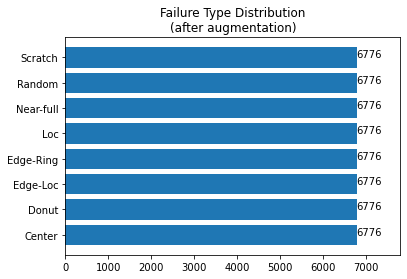

In [2]:
# sanity check
check = load('WM-clean-id224filter7-train-classify-aug.zip')
defect_distribution(check, when='after')

##### As-is (unfiltered)

In [2]:
# load data
data = load('WM-clean-id224-train.zip')

# df for classification model
def_df = data[data.detectLabels == 1]
print(len(def_df))
def_df.head()

17863


,ID,waferMap224,dieSize,lotName,failureType,dataset,detectLabels,classifyLabels
25,36,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2460.0,lot2,Edge-Loc,train,1,2
26,37,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2460.0,lot2,Edge-Loc,train,1,2
27,38,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2460.0,lot2,Edge-Loc,train,1,2
28,39,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2460.0,lot2,Loc,train,1,1
29,41,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2460.0,lot2,Edge-Loc,train,1,2


In [3]:
# figure out max count for balancing
max_count = max(def_df.groupby('classifyLabels')['ID'].count().tolist())

# dataframe for collecting all samples
aug_df = pd.DataFrame()

for i in range(8):
    labels = def_df[def_df.classifyLabels == (i+1)].index.tolist()
    label_df = def_df[def_df.classifyLabels == (i+1)][['ID', 'failureType', 'classifyLabels', 'waferMap224']]
    defect = label_df.failureType.unique()[0]
    
    # calculate how many samples are needed to balance with max class
    n = max_count - len(label_df)
    
    print(f'Augmenting class label {i+1} ({defect}) with {n} samples')
    print(f'Starting count: {len(label_df)}')
    
    if n > 0:
        
        # create new samples by flipping and rotating
        # using helper function from helpers
        new_df = flip_rotate(df=label_df, col='waferMap224', defect=defect, classLabel=(i+1), labels=labels, number=n)
        print(f'Samples created: {len(new_df)}')
        
        # concatenate augmented samples with original samples
        new_df2 = pd.concat([new_df, label_df], ignore_index=True, axis=0)
        print(f'New count: {len(new_df2)}')
        
        # collect with samples from other labels
        aug_df = pd.concat([aug_df, new_df2], ignore_index=True, axis=0)
        print(f'Total augmented df: {len(aug_df)}')
    
    else:
        
        # collect max class with samples from other labels without augmentation
        aug_df = pd.concat([aug_df, label_df], ignore_index=True, axis=0)
        print(f'Total augmented df: {len(aug_df)}')

Augmenting class label 1 (Loc) with 4261 samples
Starting count: 2515
Samples created: 4261
New count: 6776
Total augmented df: 6776
Augmenting class label 2 (Edge-Loc) with 3144 samples
Starting count: 3632
Samples created: 3144
New count: 6776
Total augmented df: 13552
Augmenting class label 3 (Center) with 3770 samples
Starting count: 3006
Samples created: 3770
New count: 6776
Total augmented df: 20328
Augmenting class label 4 (Edge-Ring) with 0 samples
Starting count: 6776
Total augmented df: 27104
Augmenting class label 5 (Scratch) with 5941 samples
Starting count: 835
Samples created: 5941
New count: 6776
Total augmented df: 33880
Augmenting class label 6 (Random) with 6170 samples
Starting count: 606
Samples created: 6170
New count: 6776
Total augmented df: 40656
Augmenting class label 7 (Near-full) with 6672 samples
Starting count: 104
Samples created: 6672
New count: 6776
Total augmented df: 47432
Augmenting class label 8 (Donut) with 6387 samples
Starting count: 389
Samples c

In [4]:
# randomly shuffle augmented df
shuffled_df = aug_df.sample(frac=1).reset_index(drop=True)
print(shuffled_df.shape)
shuffled_df.head()

(54208, 4)


,ID,classifyLabels,failureType,waferMap224
0,A,2.0,Edge-Loc,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,A,8.0,Donut,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,A,2.0,Edge-Loc,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,20497,8.0,Donut,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,95773,4.0,Edge-Ring,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


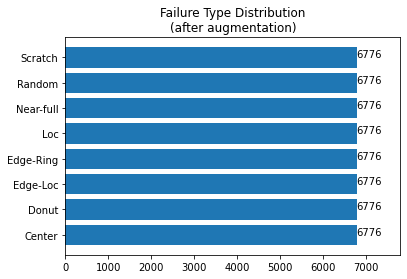

In [5]:
# sanity check
defect_distribution(shuffled_df, when='after')

In [6]:
# save(shuffled_df, 'WM-clean-id224-train-classify-aug.zip')